In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import numpy as np
import torch
import pandas as pd
import gzip
import random
import sys
from bpnetlite.io import extract_loci

import matplotlib.pyplot as plt

sys.path.append("/mnt/lab_data2/kcochran/procapnet/src/2_train_models")
sys.path.append("/mnt/lab_data2/kcochran/procapnet/src/utils")
from data_loading import extract_peaks
from performance_metrics import compute_performance_metrics



def model_predict(model, onehot_seqs):
    with torch.no_grad():
        onehot_seqs = torch.tensor(onehot_seqs, dtype=torch.float32).cuda()
        pred_profiles, pred_logcounts = model.predict(onehot_seqs)
    
    pred_profiles = pred_profiles.detach().cpu().numpy()
    pred_logcounts = pred_logcounts.detach().cpu().numpy()
    return pred_profiles, pred_logcounts


def run_eval(sequence_path, chrom_sizes, plus_bw_path, minus_bw_path, peak_path,
             pred_profiles, pred_logcounts, in_window=2114, out_window=1000):

    '''to_print = "=== Running Model Eval ==="
    to_print += "\nBigwigs:\n   - " + plus_bw_path + "\n   - " + minus_bw_path
    to_print += "\nPeaks: " + peak_path
    to_print += "\nModel: " + model_path
    to_print += "\nSequence length: " + str(in_window)
    to_print += "\nProfile length: " + str(out_window)
    to_print += "\nStranded model: " + str(stranded)
    
    to_print += "\nPred. profiles (out): " + pred_profiles_path
    to_print += "\nPred. counts (out): " + pred_logcounts_path
    to_print += "\nEval metrics (out): " + metrics_save_path
    to_print += "\nEval log (out): " + log_save_path'''

    
    # load model
    model = torch.load(model_path)
    model.eval()
    model = model.cuda()

    # load data for peak set
    onehot_seqs, true_profiles = extract_peaks(sequence_path, chrom_sizes,
        plus_bw_path, minus_bw_path, peak_path,
        in_window=in_window, out_window=out_window,
        max_jitter=0, verbose=True)

    # re-format arrays for performance metrics code
    true_profiles = true_profiles.reshape(true_profiles.shape[0], -1)
    true_profiles = np.expand_dims(true_profiles, (1, 3))
    true_counts = true_profiles.sum(axis=2)
        
    pred_profiles = pred_profiles.reshape(pred_profiles.shape[0], -1)
    pred_profiles = np.expand_dims(pred_profiles, (1, 3))
    pred_logcounts = np.expand_dims(pred_logcounts, 1)

    # print(true_profiles)
    # print(pred_profiles)
    # compute metrics
    
    plt.scatter(pred_logcounts, np.log1p(true_counts))
    
    metrics = compute_performance_metrics(true_profiles, pred_profiles, 
        true_counts, pred_logcounts, smooth_true_profs=False, smooth_pred_profs=False)

    # save metrics and log results
    df_dict = {metric : list(metrics[metric].squeeze()) for metric in ["nll", "jsd", "profile_pearson"]}
    metrics_df = pd.DataFrame(df_dict)

    metrics_to_report = ["nll", "jsd", "profile_pearson", "count_pearson", "count_mse"]
    metrics_summary = [str(metrics[metric].mean()) for metric in metrics_to_report] 

    for metric, val in zip(metrics_to_report, metrics_summary):
        print("Mean " + metric + ": " + val)
            

In [6]:
timestamp = '2023-06-14_10:16:58'
model_directory = '/users/myin25/projects/human_proseq/models'
model_path = model_directory + '/{}.final.torch'.format(timestamp)
model = torch.load(model_path)
model.eval()
model = model.cuda()

root = '/users/myin25/projects/human_proseq/data/coPRO_3prime/K562/'
peaks = root + 'peaks_fold1_train.bed.gz'
seqs = '/users/myin25/projects/human_proseq/refs/hg38.fasta'
signals = [root + '3prime.pos.bigWig', root + '3prime.neg.bigWig']
controls = None
valid_chroms = ['chr{}'.format(i) for i in range(0, 23)]
valid_chroms.append('chrX')
valid_chroms.append('chrY')

onehot_encoded_sequences, profs = extract_loci(peaks, seqs, signals, controls, chroms=valid_chroms, max_jitter=0)

pred_profiles, pred_logcounts = model_predict(model, onehot_encoded_sequences)

pred_profiles = torch.nn.Softmax()(torch.tensor(pred_profiles))
pred_profiles = pred_profiles.numpy()
pred_profiles = np.log(pred_profiles)

val_save_dir = '/users/myin25/projects/human_proseq/model_out/'
pred_logcounts_path = val_save_dir + timestamp + "_val.counts.npy"
pred_profiles_path = val_save_dir + timestamp + "_val.profs.npy"

# np.save(pred_profiles_path, pred_profiles)
# np.save(pred_logcounts_path, pred_logcounts)

print('done')

/tmp/ipykernel_7269/3622243328.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  onehot_seqs = torch.tensor(onehot_seqs, dtype=torch.float32).cuda()
/tmp/ipykernel_7269/3196015773.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_profiles = torch.nn.Softmax()(torch.tensor(pred_profiles))


done


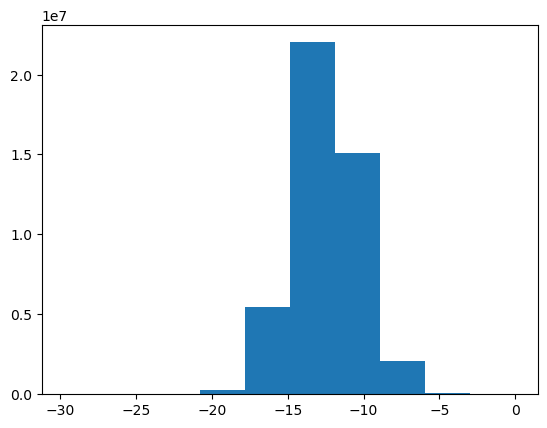

In [7]:
import matplotlib.pyplot as plt

plt.hist(pred_profiles.flatten())
plt.show()

In [4]:
pred_profiles.shape

(3699, 2, 1000)

Loading genome sequence from /users/myin25/projects/human_proseq/refs/hg38.fasta


Reading FASTA: 100%|███████████████████████████████████████████████████████████| 24/24 [00:10<00:00,  2.33it/s]
Loading Peaks: 22501it [00:39, 567.91it/s]


== In Extract Peaks ==
Peak filepath: /users/myin25/projects/human_proseq/data/coPRO_3prime/K562/peaks_fold1_train.bed.gz
Sequence length (with jitter): 2114
Profile length (with jitter): 1000
Max jitter applied: 0
Num. Examples: 22501
Mask loaded? False


/mnt/lab_data2/kcochran/procapnet/src/2_train_models/performance_metrics.py:52: RuntimeWarning: invalid value encountered in true_divide
  cross_ent = (-log_prob_pows_sum) / trials
/mnt/lab_data2/kcochran/procapnet/src/2_train_models/performance_metrics.py:243: RuntimeWarning: Mean of empty slice
  jsd_batch_mean = np.nanmean(jsd_batch, axis=-1)  # Average over strands


Mean nll: 2887.1704659410902
Mean jsd: nan
Mean profile_pearson: nan
Mean count_pearson: 0.8918529
Mean count_mse: 0.30767837


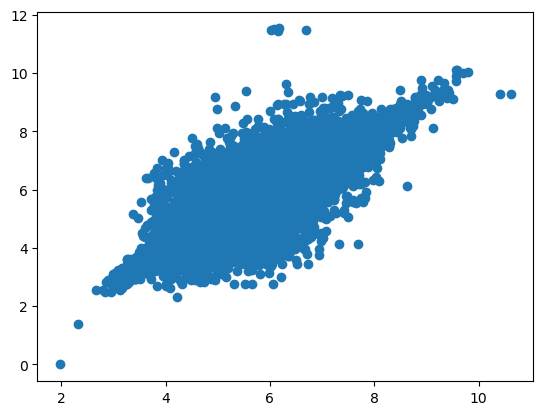

In [8]:
chrom_sizes = '/users/myin25/projects/human_proseq/refs/hg38_sizes.genome'
metrics_save_path = '/users/myin25/projects/human_proseq/model_out/2023-06-14_10:16:58.metrics'
log_save_path = '/users/myin25/projects/human_proseq/model_out/2023-06-14_10:16:58.log'

run_eval(seqs, chrom_sizes, signals[0], signals[1], peaks,
             pred_profiles, pred_logcounts, in_window=2114, out_window=1000)